In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
import torch

In [31]:
# Install and configure wandb
import wandb
# Login to wandb (you'll need to enter your API key when prompted)
wandb.login()  # Uncomment this line and run to login with your API key

True

In [32]:
from ACAgraphML.Dataset import ZINC_Dataset

NUM_NODE_FEATS = 28
NUM_EDGE_FEATS = 4

trainDataset = ZINC_Dataset.SMALL_TRAIN.load()
valDataset = ZINC_Dataset.SMALL_VAL.load()

In [33]:
len(trainDataset), len(valDataset), torch.min(trainDataset.data.y), torch.max(trainDataset.data.y)

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


(10000, 1000, tensor(-42.0366), tensor(3.8048))

Target statistics: mean=0.0153, std=2.0109
Range: [-42.0366, 3.8048]


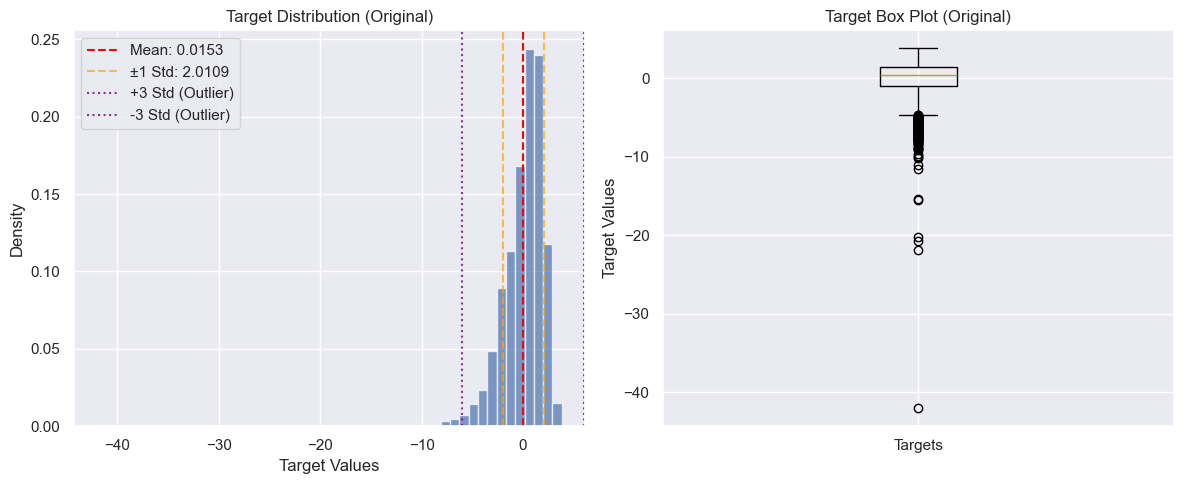

====== Filtering and Normalizing TRAIN ======


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


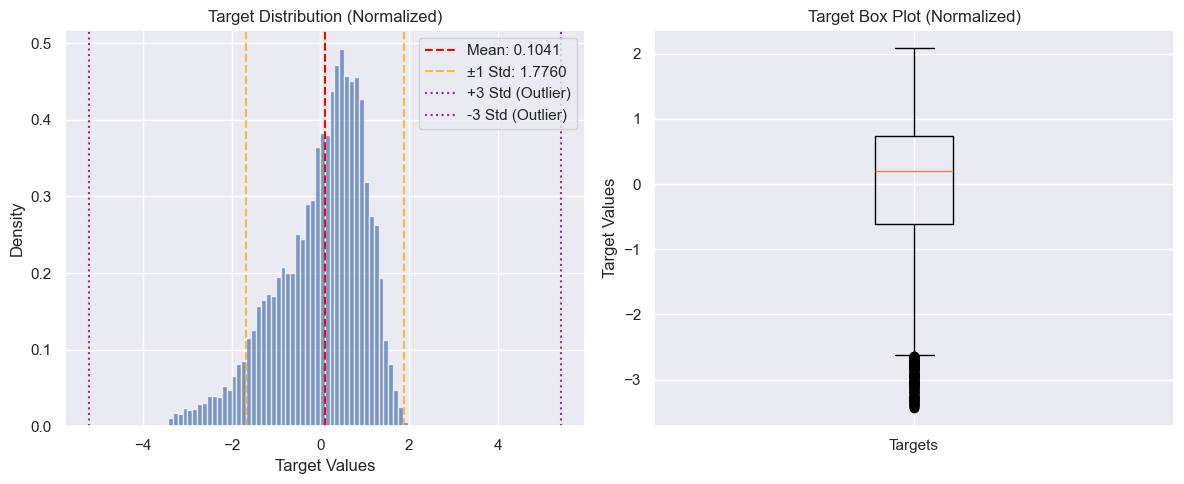

====== Filtering and Normalizing VAL ======


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


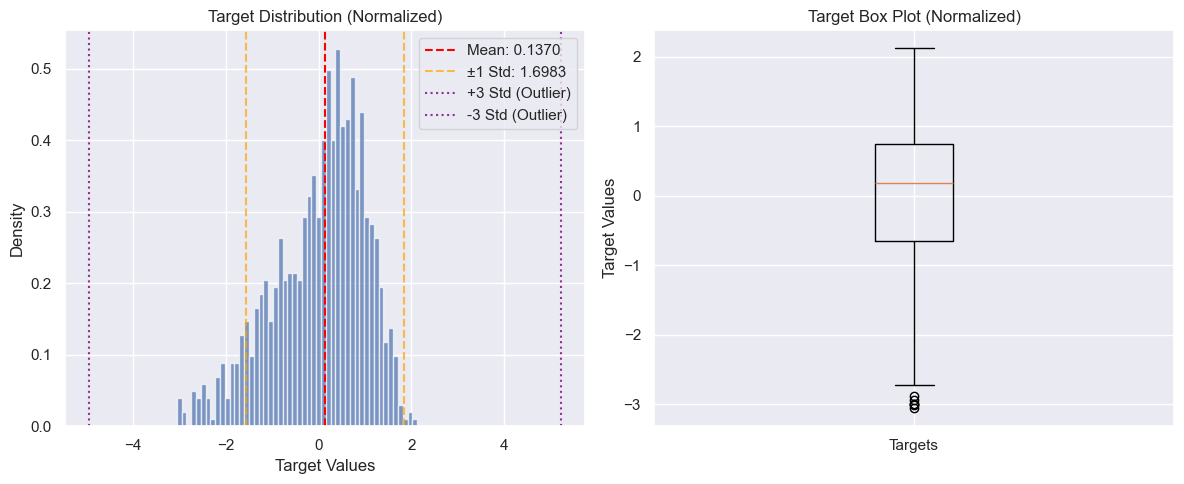

====== Filtering and Normalizing DONE ======

Dataset sizes after filtering:
Training: 9893 (was 10000)
Validation: 988 (was 1000)

Min and max of targets in normalized datasets:
Train: -3.4398, 2.0837
Val: -3.0586, 2.1231

 Mean and std of targets in normalized datasets:
Train: -0.0000, 1.0000, original: 0.0153, 2.0109
Val: -0.0000, 1.0000, original: 0.0315, 1.9856

=== Testing normalization ===
Sample train target: 0.4115
Sample val target: 0.2903


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `

(9893, 988)

In [34]:
from ACAgraphML.Pipeline import TargetNormalizer

# Create the normalizer and fit it to the training data
target_normalizer = TargetNormalizer(verbose=True)
target_normalizer.fit(trainDataset)

# Create filtered and normalized datasets
print('====== Filtering and Normalizing TRAIN ======')
normalized_train_dataset = target_normalizer.normalize(trainDataset)
print('====== Filtering and Normalizing VAL ======')
normalized_val_dataset = target_normalizer.normalize(valDataset)
print('====== Filtering and Normalizing DONE ======')

print(f"\nDataset sizes after filtering:")
print(f"Training: {len(normalized_train_dataset)} (was {len(trainDataset)})")
print(f"Validation: {len(normalized_val_dataset)} (was {len(valDataset)})")

#print min and max of the targets in the normalized datasets
print(f"\nMin and max of targets in normalized datasets:")
print(f"Train: {torch.min(normalized_train_dataset.y):.4f}, {torch.max(normalized_train_dataset.y):.4f}")
print(f"Val: {torch.min(normalized_val_dataset.y):.4f}, {torch.max(normalized_val_dataset.y):.4f}")

print(f"\n Mean and std of targets in normalized datasets:")
print(f"Train: {normalized_train_dataset.y.mean().item():.4f}, {normalized_train_dataset.y.std().item():.4f}, original: {trainDataset.data.y.mean().item():.4f}, {trainDataset.data.y.std().item():.4f}")
print(f"Val: {normalized_val_dataset.y.mean().item():.4f}, {normalized_val_dataset.y.std().item():.4f}, original: {valDataset.data.y.mean().item():.4f}, {valDataset.data.y.std().item():.4f}")

# Test that the normalization works
print(f"\n=== Testing normalization ===")
sample_train = normalized_train_dataset[0]
sample_val = normalized_val_dataset[0]
print(f"Sample train target: {sample_train.y.item():.4f}")
print(f"Sample val target: {sample_val.y.item():.4f}")

len(normalized_train_dataset), len(normalized_val_dataset)

In [35]:
from ACAgraphML.Transforms import SteadyStateTransform, OneHotEncodeFeat, OneHotEdgeFeats, AddMasterNode
from ACAgraphML.Pipeline import DataAugmenter
from torch_geometric.transforms import AddRandomWalkPE, AddLaplacianEigenvectorPE

addMasterNodeTransform = AddMasterNode()
oneHotEncodeFeatTransform = OneHotEncodeFeat(nClasses=NUM_NODE_FEATS)
oneHotEncodeFeatTransformEdge = OneHotEdgeFeats(nClasses=NUM_EDGE_FEATS)
steadyStateTransform = SteadyStateTransform(useEdgeWeights=False)
randomWalkPETransform = AddRandomWalkPE(walk_length=10, attr_name=None)
lapEigvecs = AddLaplacianEigenvectorPE(k=5, attr_name=None, normalization='sym', is_undirected=True)

transforms = [
    addMasterNodeTransform,
    oneHotEncodeFeatTransform,
    oneHotEncodeFeatTransformEdge,
    steadyStateTransform,
    randomWalkPETransform,
    lapEigvecs
]

trainAugmented = DataAugmenter(
    dataset=normalized_train_dataset,
    transforms=transforms
).augment()

valAugmented = DataAugmenter(
    dataset=normalized_val_dataset,
    transforms=transforms
).augment()

trainAugmented.x.shape, trainAugmented[0].x.shape, valAugmented.x.shape, valAugmented[0].x.shape 

Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/988 [00:00<?, ?it/s]

(torch.Size([239124, 44]),
 torch.Size([30, 44]),
 torch.Size([23824, 44]),
 torch.Size([36, 44]))

Number of components to keep: 23
Explained variance ratio: 0.9999184608459473
Using saved principal directions.


(torch.Size([239124, 23]),
 torch.Size([30, 23]),
 torch.Size([23824, 23]),
 torch.Size([36, 23]))

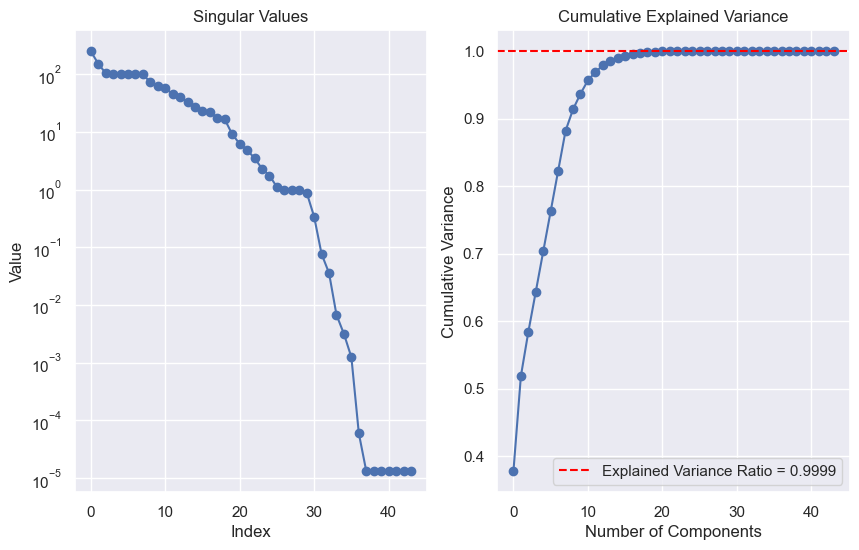

In [36]:
from ACAgraphML.Pipeline import DimentionalityReduction
dimentionalityReduction = DimentionalityReduction(explained_variance_ratio=0.9999, verbose=True)

trainDatasetReduced = dimentionalityReduction(trainAugmented)
valDatasetReduced = dimentionalityReduction(valAugmented, useState=True)

REDUCED_NUM_NODE_FEATS = trainDatasetReduced[0].x.shape[1]

trainDatasetReduced.x.shape, trainDatasetReduced[0].x.shape, valDatasetReduced.x.shape, valDatasetReduced[0].x.shape

In [37]:
import dotenv

# Load environment variables from .env file
dotenv.load_dotenv()

SUPABASE_URL = dotenv.get_key('.env', 'SUPABASE_URL')
if SUPABASE_URL is None:
    raise ValueError("SUPABASE_URL not found in .env file. Please set it to your Supabase database URL.")
else:
    print("SUPABASE_URL loaded successfully.")

SUPABASE_URL loaded successfully.


In [38]:
from ACAgraphML.Pipeline.Models.GDLPipeline import GNNConfig, PoolingConfig, RegressorConfig
from ACAgraphML.Pipeline.LightningModules import GDLPipelineLightningModule, create_lightning_baseline, create_lightning_standard, create_lightning_attention, create_lightning_advanced
from ACAgraphML.utils import get_model_memory_usage, get_comprehensive_model_info, print_model_summary, measure_inference_latency


# Defining the model with Optuna - focused on key hyperparameters for ZINC regression
def defineModel(trial, verbose=False):
    """
    Creates a GDLPipelineLightningModule with Optuna-optimized hyperparameters.
    
    Focus areas for ZINC dataset:
    1. Architecture: GNN layer type, depth, and width
    2. Learning: Learning rate and weight decay  
    3. Regularization: Dropout rates
    4. Pooling strategy for graph-level prediction
    5. Regressor architecture: Critical for final prediction quality
    """
    
    # 1. GNN Architecture - Most critical for performance
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 3, 6)
    layer_name = trial.suggest_categorical('layer_name', ['GINEConv', 'GAT', 'GATv2', 'SAGE'])
    
    # 2. Regularization - Important for generalization
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3, step=0.05)
    global_dropout = trial.suggest_float('global_dropout', 0.0, 0.2, step=0.05)
    
    # 3. Learning parameters - Critical for convergence
    lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    
    # 4. Pooling strategy - Important for graph-level tasks
    pooling_type = trial.suggest_categorical('pooling_type', ['mean', 'attentional', 'set2set'])
    
    # 5. Regressor architecture - Critical for final prediction quality
    regressor_type = trial.suggest_categorical('regressor_type', ['linear', 'mlp', 'residual_mlp', 'ensemble_mlp'])
    
    # Create custom configurations
    
    gnn_config = GNNConfig(
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        layer_name=layer_name,
        dropout_rate=dropout_rate
    )
    
    pooling_config = PoolingConfig(
        pooling_type=pooling_type
    )
    
    # Configure regressor based on type with optimized architecture
    if regressor_type == 'linear':
        regressor_config = RegressorConfig(regressor_type='linear')
    else:
        # For MLP types, optimize the architecture
        # Number of hidden layers (depth)
        num_regressor_layers = trial.suggest_int('regressor_num_layers', 1, 3)
        
        # Hidden dimension for first layer (usually larger)
        first_hidden = trial.suggest_categorical('regressor_first_hidden', [128, 256, 512])
        
        # Create architecture based on number of layers
        if num_regressor_layers == 1:
            hidden_dims = [first_hidden]
        elif num_regressor_layers == 2:
            second_hidden = trial.suggest_categorical('regressor_second_hidden', [64, 128, 256])
            # Ensure decreasing size: first >= second
            if second_hidden > first_hidden:
                second_hidden = first_hidden // 2 if first_hidden > 64 else first_hidden
            hidden_dims = [first_hidden, second_hidden]
        else:  # 3 layers
            second_hidden = trial.suggest_categorical('regressor_second_hidden', [64, 128, 256])
            third_hidden = trial.suggest_categorical('regressor_third_hidden', [32, 64, 128])
            # Ensure reasonable decreasing sizes
            if second_hidden > first_hidden:
                second_hidden = first_hidden // 2 if first_hidden > 64 else first_hidden
            if third_hidden > second_hidden:
                third_hidden = second_hidden // 2 if second_hidden > 32 else second_hidden
            hidden_dims = [first_hidden, second_hidden, third_hidden]
        
        # Regressor-specific dropout (independent from GNN dropout)
        regressor_dropout = trial.suggest_float('regressor_dropout', 0.0, 0.3, step=0.05)
        
        regressor_config = RegressorConfig(
            regressor_type=regressor_type,
            hidden_dims=hidden_dims,
            normalization=trial.suggest_categorical('regressor_normalization', ['batch', 'none']),
            linear_dropout=regressor_dropout,
            attention_dropout=regressor_dropout,
            residual_dropout=regressor_dropout
        )
    
    # Create the Lightning module
    model = GDLPipelineLightningModule(
        node_features=REDUCED_NUM_NODE_FEATS,
        edge_features=NUM_EDGE_FEATS,
        pipeline_config="custom",
        gnn_config=gnn_config,
        pooling_config=pooling_config,
        regressor_config=regressor_config,
        global_dropout=global_dropout,
        lr=lr,
        weight_decay=weight_decay,
        # Fixed good defaults for ZINC
        optimizer='adamw',
        lr_scheduler='cosine',
        loss='mae',  # MAE is robust for ZINC target distribution
        warmup_epochs=5,
        gradient_clip_val=1.0
    )
    
    if verbose:
        print(model)
        print_model_summary(model)
        # Fix the memory usage call - get_model_memory_usage might return a dict
        # memory_info = get_model_memory_usage(model)
        # print(f"Model memory usage: {memory_info}")
        # print(get_comprehensive_model_info(model))
        
    return model


In [39]:
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
import time
import os

def trainModel(model, trainDataset, validationDataset, max_epochs=25, patience=8, batch_size=32, verbose=False, wandb_logger=None):
    """
    Train model for Optuna optimization - focused on efficiency and validation performance.
    
    Args:
        model: GDLPipelineLightningModule to train
        trainDataset: Training dataset to use
        validationDataset: Validation dataset to use
        max_epochs: Maximum training epochs (reduced for faster optimization)
        patience: Early stopping patience
        batch_size: Batch size for data loaders
        verbose: Whether to show progress bars
        wandb_logger: Optional W&B logger for experiment tracking
    
    Returns:
        tuple: (best_val_mae, training_time, latency)
    """
    
    # Ensure model is in training mode
    model.train()
    
    # Create data loaders with specified batch size using the provided datasets
    train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(validationDataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # measure latency - fix the input function to return proper components
    def create_single_graph_input():
        sample = trainDataset[0]
        device = next(model.parameters()).device
        return (sample.x.to(device), sample.edge_index.to(device), sample.edge_attr.to(device), torch.zeros(sample.x.size(0), dtype=torch.long, device=device))
    
    # Set model to eval mode temporarily for latency measurement
    model.eval()
    latency = measure_inference_latency(model, create_single_graph_input, num_runs=3, warmup_runs=1)['mean_latency_ms']
    model.train()  # Back to training mode
    
    # Create checkpoint directory for this trial
    checkpoint_dir = "saved_models/Pipeline/Optuna/" if wandb_logger else "saved_models/Pipeline/temp/"
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Configure callbacks for optimization
    callbacks = [
        pl.callbacks.ModelCheckpoint(
            dirpath=checkpoint_dir,
            monitor='val_mae',
            mode='min',
            save_top_k=1,
            save_weights_only=False,  # Save full model for W&B artifacts
            verbose=False,
            filename='best-model-{epoch:02d}-{val_mae:.4f}' if wandb_logger else 'best-model'
        ),
        pl.callbacks.EarlyStopping(
            monitor='val_mae',
            patience=patience,
            mode='min',
            verbose=False
        )
    ]
    
    # Create trainer optimized for speed and GPU usage
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        callbacks=callbacks,
        enable_progress_bar=verbose,  # Disable for cleaner Optuna output
        enable_model_summary=verbose,  # Disable for speed
        logger=wandb_logger if wandb_logger else False,  # Use W&B logger if provided
        enable_checkpointing=True,
        deterministic=False,  # Allow non-deterministic for speed
        precision='16-mixed' if torch.cuda.is_available() else 32,  # Mixed precision for GPU speedup
    )
    
    try:
        start_time = time.perf_counter()
        # Train the model
        trainer.fit(model, train_loader, val_loader)
        end_time = time.perf_counter()

        #Compute training speed
        training_time = (end_time - start_time)/60  / max_epochs
        if verbose:
            print(f"Training completed in {training_time:.2f} seconds per epoch.")
        
        # Return best validation MAE
        best_mae = trainer.callback_metrics.get('val_mae', float('inf'))
        
        # Handle tensor to float conversion
        if hasattr(best_mae, 'item'):
            best_mae = best_mae.item()
        
        # Save model checkpoint as W&B artifact if logger is provided
        if wandb_logger and trainer.checkpoint_callback.best_model_path:
            try:
                import wandb
                # Create artifact for the best model checkpoint
                artifact = wandb.Artifact(
                    name=f"model-checkpoint-trial",
                    type="model",
                    description=f"Best model checkpoint with val_mae={best_mae:.4f}",
                    metadata={
                        "val_mae": best_mae,
                        "training_time_ms_per_epoch": training_time,
                        "inference_latency_ms": latency,
                        "epochs_trained": trainer.current_epoch + 1,
                        "patience": patience,
                        "batch_size": batch_size
                    }
                )
                
                # Add the checkpoint file to the artifact
                artifact.add_file(trainer.checkpoint_callback.best_model_path)
                
                # Log the artifact to W&B
                wandb_logger.experiment.log_artifact(artifact)
                
                if verbose:
                    print(f"Model checkpoint saved as W&B artifact: {trainer.checkpoint_callback.best_model_path}")
                    
            except Exception as e:
                print(f"Warning: Failed to save checkpoint as W&B artifact: {e}")
            
        return best_mae, training_time, latency
        
    except Exception as e:
        print(f"Training failed: {e}")
        return float('inf'), float('inf'), float('inf')  # Return worst possible score on failure
    
    finally:
        # Clean up GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

In [40]:
from lightning.pytorch import loggers as pl_loggers
from datetime import datetime
import wandb

VERBOSE = True
def objective(trial, trainDataset=trainDatasetReduced, validationDataset=valDatasetReduced):
    """
    Optuna objective function with W&B integration for each trial.
    """

    # Clean up any existing W&B run
    if wandb.run is not None:
        wandb.finish()
    
    # Create unique run name for this trial
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"Optuna-Trial-{trial.number}-{timestamp}"
    
    # Create W&B logger for this trial
    wandb_logger = pl_loggers.WandbLogger(
        project="ACA-GraphML-Optuna",
        name=run_name,
        tags=["optuna", "hyperparameter_optimization", "ZINC"],
        reinit=True,
        id=None,  # Let W&B generate unique ID
        save_dir="saved_models/Pipeline/Optuna/",
        log_model="all",  # Enable automatic model logging
    )
    
    try:
        # Build the model with Optuna-optimized hyperparameters
        model = defineModel(trial, verbose=VERBOSE)

        model_info = get_comprehensive_model_info(model, include_hparams=True)
        totalParams = model_info['model/total_parameters']
        gnnParams = model_info['model/gnn_parameters']
        poolingParams = model_info['model/pooling_parameters']
        regressorParams = model_info['model/regressor_parameters']
        
        # Log trial hyperparameters to W&B
        trial_params = trial.params.copy()
        trial_params.update({
            'trial_number': trial.number,
            'total_parameters': totalParams,
            'gnn_parameters': gnnParams,
            'pooling_parameters': poolingParams,
            'regressor_parameters': regressorParams,
            'hyperparameters': model_info
        })
        wandb_logger.log_hyperparams(trial_params)
        
        # Log model architecture summary
        wandb_logger.experiment.log({
            "model_summary": str(model),
            "model_architecture": {
                "total_params": totalParams,
                "gnn_params": gnnParams,
                "pooling_params": poolingParams,
                "regressor_params": regressorParams
            }
        })

        # Train the model with the given datasets and W&B logging
        best_val_mae, trainingTime, latency = trainModel(
            model, trainDataset, validationDataset, 
            max_epochs=1, patience=8, batch_size=32,  # Restored original max_epochs for better training
            verbose=VERBOSE, wandb_logger=wandb_logger
        )
        
        # Log final metrics to W&B
        wandb_logger.experiment.log({
            "final_val_mae": best_val_mae,
            "training_time_ms_per_epoch": trainingTime,
            "inference_latency_ms": latency,
            "trial_number": trial.number,
            "optimization_objective": best_val_mae,  # Primary metric for Optuna
        })
        
        # Add summary of trial results
        wandb_logger.experiment.summary.update({
            "best_val_mae": best_val_mae,
            "total_parameters": totalParams,
            "training_efficiency": trainingTime,
            "inference_speed": latency,
            "trial_status": "completed"
        })

        return best_val_mae, totalParams, gnnParams, poolingParams, regressorParams, trainingTime, latency
    
    except Exception as e:
        # Log error to W&B if something goes wrong
        wandb_logger.experiment.log({
            "error": str(e), 
            "trial_number": trial.number,
            "trial_status": "failed"
        })
        wandb_logger.experiment.summary.update({
            "trial_status": "failed",
            "error_message": str(e)
        })
        print(f"Trial {trial.number} failed: {e}")
        return float('inf'), float('inf'), float('inf'), float('inf'), float('inf'), float('inf'), float('inf')
    
    finally:
        # Ensure W&B run is properly finished
        if wandb.run is not None:
            wandb.finish()

In [41]:
import optuna
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

# Create Optuna study with Supabase storage and TPE sampler
storage = RDBStorage(url=SUPABASE_URL)

study = optuna.create_study(
    study_name='ZINC_GDL_Pipeline_Optimization',
    storage=storage,
    directions= ['minimize', 'minimize', 'minimize', 'minimize', 'minimize', 'minimize', 'minimize'],
    load_if_exists=True,
    sampler=TPESampler()
)

print(f"Study created: {study.study_name}")
print(f"Sampler: {type(study.sampler).__name__}")
print(f"Existing trials: {len(study.trials)}")

[I 2025-06-29 23:54:18,286] Using an existing study with name 'ZINC_GDL_Pipeline_Optimization' instead of creating a new one.


Study created: ZINC_GDL_Pipeline_Optimization
Sampler: TPESampler
Existing trials: 20
Existing trials: 20


In [ ]:
# Run the optimization - each trial will save checkpoints to W&B
study.optimize(objective, n_trials=5)

print("\n=== Optuna Optimization Complete ===")
print(f"Number of finished trials: {len(study.trials)}")

if len(study.trials) > 0:
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best MAE: {study.best_trial.values[0]:.4f}")
    
    print(f"\n💾 **Model Checkpoints Saved to W&B:**")
    print(f"- All trial checkpoints available as W&B artifacts")
    print(f"- Project: ACA-GraphML-Optuna")
    print(f"- Each artifact includes model file + performance metadata")
    print(f"- Use download_best_checkpoint_from_wandb() to retrieve best model")
else:
    print("No trials completed.")

GDLPipelineLightningModule(
  (pipeline): GDLPipeline(
    (gnn): GNNModel(
      (input_proj): Linear(in_features=23, out_features=64, bias=True)
      (gnn_layers): ModuleList(
        (0-2): 3 x GINEConv(nn=Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=64, bias=True)
        ))
      )
      (layer_norms): ModuleList(
        (0-2): 3 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (dropouts): ModuleList(
        (0-2): 3 x Dropout(p=0.3, inplace=False)
      )
    )
    (pooling): Pooling(
      (pooling_layer): AttentionalPooling(
        (attention_layer): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=1, bias=True)
        )
      )
    )
    (graph_dropout): Identity()
    (graph_batch_norm): Identity()
    (regressor): Regressor(
      (regressor): 

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:658: Checkpoint directory C:\Polimi\Master\2Sem\ACA_GraphML_Project\Notebooks\saved_models\Pipeline\Optuna exists and is not empty.

  | Name     | Type        | Params | Mode
------------------------------------------------
0 | pipeline | GDLPipeline | 221 K  | eval
1 | loss_fn  | L1Loss      | 0      | eval
------------------------------------------------
221 K     Trainable params
0         Non-trainable params
221 K     Total params
0.887     Total estimated model params size (MB)
0         Modules in train mode
52        Modules in eval mode
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:658: Checkpoint directory C:\

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Training completed in 19587.96 seconds per epoch.
Model checkpoint saved as W&B artifact: C:\Polimi\Master\2Sem\ACA_GraphML_Project\Notebooks\saved_models\Pipeline\Optuna\best-model-epoch=00-val_mae=0.4669.ckpt
Model checkpoint saved as W&B artifact: C:\Polimi\Master\2Sem\ACA_GraphML_Project\Notebooks\saved_models\Pipeline\Optuna\best-model-epoch=00-val_mae=0.4669.ckpt


epoch,▁▁▁▁▁▁▁▁
final_val_mae,▁
inference_latency_ms,▁
lr,▁▁▁▁▁▁
optimization_objective,▁
train_loss_epoch,▁
train_loss_step,█▇▇▃▃▁
train_mae,▁
train_max_error,▁
train_mean_abs_error,▁
train_predictions_mean,▁


[I 2025-06-29 20:44:30,973] Trial 3 finished with values: [0.466885924339294, 221698.0, 52608.0, 4225.0, 164865.0, 19587.9601000343, 1.83600001037121] and parameters: {'hidden_dim': 64, 'num_layers': 3, 'layer_name': 'GINEConv', 'dropout_rate': 0.3, 'global_dropout': 0.0, 'lr': 0.000539635196098736, 'weight_decay': 2.80850013245898e-05, 'pooling_type': 'attentional', 'regressor_type': 'mlp', 'regressor_num_layers': 2, 'regressor_first_hidden': 512, 'regressor_second_hidden': 256, 'regressor_dropout': 0.3, 'regressor_normalization': 'none'}.


GDLPipelineLightningModule(
  (pipeline): GDLPipeline(
    (gnn): GNNModel(
      (input_proj): Linear(in_features=23, out_features=128, bias=True)
      (gnn_layers): ModuleList(
        (0-4): 5 x GATConv(128, 128, heads=8)
      )
      (layer_norms): ModuleList(
        (0-4): 5 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (dropouts): ModuleList(
        (0-4): 5 x Dropout(p=0.15000000000000002, inplace=False)
      )
    )
    (pooling): Pooling(
      (pooling_layer): Set2Set(128, 256)
    )
    (graph_dropout): Dropout(p=0.2, inplace=False)
    (graph_batch_norm): Identity()
    (regressor): Regressor(
      (regressor): MLPRegressor(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.15, inplace=False)
          (4): Linear(in_features=256, out_features=64

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params | Mode
------------------------------------------------
0 | pipeline | GDLPipeline | 976 K  | eval
1 | loss_fn  | L1Loss      | 0      | eval
------------------------------------------------
976 K     Trainable params
0         Non-trainable params
976 K     Total params
3.907     Total estimated model params size (MB)
0         Modules in train mode
54        Modules in eval mode
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params | Mode
------------------------------------------------
0 | pipeline | GDLPipeline | 976 K  | eval
1 | loss_fn  | L1Loss      | 0      | eval
------------------------------------------------
976 K     Trainable params
0         Non-trainable params
976 K     Total params
3.907     Total estimated model params size (MB)
0         Modules in train mode
5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Training completed in 89400.01 seconds per epoch.
Model checkpoint saved as W&B artifact: C:\Polimi\Master\2Sem\ACA_GraphML_Project\Notebooks\saved_models\Pipeline\Optuna\best-model-epoch=00-val_mae=0.7882.ckpt
Model checkpoint saved as W&B artifact: C:\Polimi\Master\2Sem\ACA_GraphML_Project\Notebooks\saved_models\Pipeline\Optuna\best-model-epoch=00-val_mae=0.7882.ckpt


epoch,▁▁▁▁▁▁▁▁
final_val_mae,▁
inference_latency_ms,▁
lr,▁▁▁▁▁▁
optimization_objective,▁
train_loss_epoch,▁
train_loss_step,▇█▂▄▁▄
train_mae,▁
train_max_error,▁
train_mean_abs_error,▁
train_predictions_mean,▁


[I 2025-06-29 20:46:23,260] Trial 4 finished with values: [0.788218080997467, 976769.0, 696192.0, 197632.0, 82945.0, 89400.0058999518, 15.4700332786888] and parameters: {'hidden_dim': 128, 'num_layers': 5, 'layer_name': 'GAT', 'dropout_rate': 0.15, 'global_dropout': 0.2, 'lr': 0.0027102166073722, 'weight_decay': 0.00036400323774319, 'pooling_type': 'set2set', 'regressor_type': 'mlp', 'regressor_num_layers': 2, 'regressor_first_hidden': 256, 'regressor_second_hidden': 64, 'regressor_dropout': 0.05, 'regressor_normalization': 'batch'}.


GDLPipelineLightningModule(
  (pipeline): GDLPipeline(
    (gnn): GNNModel(
      (input_proj): Linear(in_features=23, out_features=256, bias=True)
      (gnn_layers): ModuleList(
        (0-4): 5 x GATv2Conv(256, 256, heads=8)
      )
      (layer_norms): ModuleList(
        (0-4): 5 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (dropouts): ModuleList(
        (0-4): 5 x Dropout(p=0.15000000000000002, inplace=False)
      )
    )
    (pooling): Pooling(
      (pooling_layer): AttentionalPooling(
        (attention_layer): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): Tanh()
          (2): Linear(in_features=256, out_features=1, bias=True)
        )
      )
    )
    (graph_dropout): Dropout(p=0.2, inplace=False)
    (graph_batch_norm): Identity()
    (regressor): Regressor(
      (regressor): MLPRegressor(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params | Mode
------------------------------------------------
0 | pipeline | GDLPipeline | 5.7 M  | eval
1 | loss_fn  | L1Loss      | 0      | eval
------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.621    Total estimated model params size (MB)
0         Modules in train mode
62        Modules in eval mode

  | Name     | Type        | Params | Mode
------------------------------------------------
0 | pipeline | GDLPipeline | 5.7 M  | eval
1 | loss_fn  | L1Loss      | 0      | eval
------------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params
22.621    Total estimated model params size (MB)
0         Modules in train mode
6

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


Training failed: name 'exit' is not defined


epoch,▁▁
lr,▁▁
train_loss_step,▁█
trainer/global_step,▁▄██
trial_number,▁
best_val_mae,inf
epoch,0
final_val_mae,inf
inference_latency_ms,inf
inference_speed,inf
lr,0.00043


[I 2025-06-29 20:47:55,081] Trial 5 finished with values: [inf, 5655298.0, 5324544.0, 66049.0, 264705.0, inf, inf] and parameters: {'hidden_dim': 256, 'num_layers': 5, 'layer_name': 'GATv2', 'dropout_rate': 0.15, 'global_dropout': 0.2, 'lr': 0.00215161219105079, 'weight_decay': 1.334692158553e-06, 'pooling_type': 'attentional', 'regressor_type': 'mlp', 'regressor_num_layers': 2, 'regressor_first_hidden': 512, 'regressor_second_hidden': 256, 'regressor_dropout': 0.0, 'regressor_normalization': 'batch'}.


GDLPipelineLightningModule(
  (pipeline): GDLPipeline(
    (gnn): GNNModel(
      (input_proj): Linear(in_features=23, out_features=256, bias=True)
      (gnn_layers): ModuleList(
        (0-2): 3 x SAGEConv(256, 256, aggr=mean)
      )
      (layer_norms): ModuleList(
        (0-2): 3 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (dropouts): ModuleList(
        (0-2): 3 x Dropout(p=0.15000000000000002, inplace=False)
      )
    )
    (pooling): Pooling(
      (pooling_layer): Set2Set(256, 512)
    )
    (graph_dropout): Dropout(p=0.1, inplace=False)
    (graph_batch_norm): Identity()
    (regressor): Regressor(
      (regressor): ResidualMLPRegressor(
        (input_proj): Linear(in_features=512, out_features=128, bias=True)
        (residual_blocks): ModuleList(
          (0-2): 3 x ResidualBlock(
            (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (linear1): Linear(in_features=128, out_features=25

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params | Mode
------------------------------------------------
0 | pipeline | GDLPipeline | 1.5 M  | eval
1 | loss_fn  | L1Loss      | 0      | eval
------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.824     Total estimated model params size (MB)
0         Modules in train mode
53        Modules in eval mode
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params | Mode
------------------------------------------------
0 | pipeline | GDLPipeline | 1.5 M  | eval
1 | loss_fn  | L1Loss      | 0      | eval
------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.824     Total estimated model params size (MB)
0         Modules in train mode
5

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [42]:
from ACAgraphML.Pipeline.LightningModules import GDLPipelineLightningModule

In [48]:
# 🚀 Load Best Model from W&B (Simple & Quick)
import wandb
import os
import torch

def load_best_wandb_model():
    """Download and load the best model from W&B - simplified approach."""
    try:
        api = wandb.Api()
        runs = api.runs("ACA-GraphML-Optuna")
        
        best_artifact = None
        best_mae = float('inf')
        
        # Check each run for model artifacts with MAE metadata
        for run in runs:
            try:
                # Get all artifacts from this run
                for artifact in run.logged_artifacts():
                    if artifact.type == 'model' and hasattr(artifact, 'metadata') and artifact.metadata:
                        if 'val_mae' in artifact.metadata:
                            mae = float(artifact.metadata['val_mae'])
                            if mae < best_mae:
                                best_mae = mae
                                best_artifact = artifact
                                print(f"Found better model: MAE = {mae:.4f}")
            except Exception as e:
                continue
        
        if best_artifact is None:
            print("❌ No model artifacts found with MAE metadata")
            return None
        
        print(f"✅ Best artifact found with MAE = {best_mae:.4f}")
        
        # Download and load the best model
        artifact_dir = best_artifact.download("./temp_model")
        checkpoint_file = [f for f in os.listdir(artifact_dir) if f.endswith('.ckpt')][0]
        checkpoint_path = os.path.join(artifact_dir, checkpoint_file)
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = GDLPipelineLightningModule.load_from_checkpoint(checkpoint_path, map_location=device)
        if torch.cuda.is_available():
            model = model.cuda()
        print(f"✅ Model loaded on {device}!")
        
        return model
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Load the best model (uncomment to use)
# best_wandb_model = load_best_wandb_model()

# Alternative: Test first, then load
best_wandb_model = load_best_wandb_model()  # Load best model
print(best_wandb_model)

Found better model: MAE = 0.4669
Found better model: MAE = 0.4445
Found better model: MAE = 0.4445
Found better model: MAE = 0.4398
Found better model: MAE = 0.4398
✅ Best artifact found with MAE = 0.4398
✅ Best artifact found with MAE = 0.4398


wandb:   1 of 1 files downloaded.  


✅ Model loaded on cpu!
GDLPipelineLightningModule(
  (pipeline): GDLPipeline(
    (gnn): GNNModel(
      (input_proj): Linear(in_features=23, out_features=128, bias=True)
      (gnn_layers): ModuleList(
        (0-4): 5 x GATConv(128, 128, heads=8)
      )
      (layer_norms): ModuleList(
        (0-4): 5 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (dropouts): ModuleList(
        (0-4): 5 x Dropout(p=0.15000000000000002, inplace=False)
      )
    )
    (pooling): Pooling(
      (pooling_layer): AttentionalPooling(
        (attention_layer): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Tanh()
          (2): Linear(in_features=128, out_features=1, bias=True)
        )
      )
    )
    (graph_dropout): Dropout(p=0.15000000000000002, inplace=False)
    (graph_batch_norm): Identity()
    (regressor): Regressor(
      (regressor): MLPRegressor(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_f

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


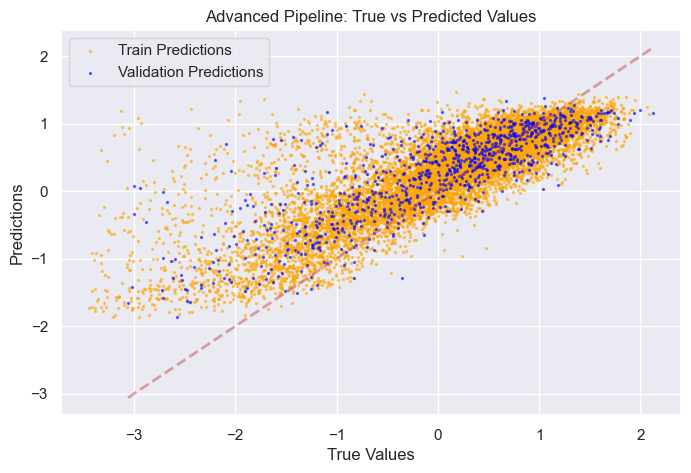

In [49]:
from ACAgraphML.utils import plotTrueVsPred

bestModel = best_wandb_model
# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bestModel = bestModel.to(device)

train_loader = DataLoader(trainDatasetReduced, batch_size=32, shuffle=False)
val_loader = DataLoader(valDatasetReduced, batch_size=32, shuffle=False)

train_predictions = []
for batch in train_loader:
    # Move batch to GPU
    batch = batch.to(device)
    prediction = bestModel.predict(
        x = batch.x,
        edge_index = batch.edge_index,
        edge_attr = batch.edge_attr,
        batch = batch.batch
    )
    train_predictions.append(prediction.cpu())  # Move back to CPU for concatenation
train_predictions = torch.cat(train_predictions, dim=0)

val_predictions = []
for batch in val_loader:
    # Move batch to GPU  
    batch = batch.to(device)
    prediction = bestModel.predict(
        x = batch.x,
        edge_index = batch.edge_index,
        edge_attr = batch.edge_attr,
        batch = batch.batch
    )
    val_predictions.append(prediction.cpu())  # Move back to CPU for concatenation
val_predictions = torch.cat(val_predictions, dim=0)

# Plot true vs predicted values
plotTrueVsPred(
    y = trainDatasetReduced.data.y,
    y_pred = train_predictions,
    y_val= valDatasetReduced.data.y,
    y_val_pred = val_predictions,
    title = "Pipeline Best: True vs Predicted Values",
    filename= "saved_models/Pipeline/BEST/true_vs_pred.png",
    hardLimit=False
)

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


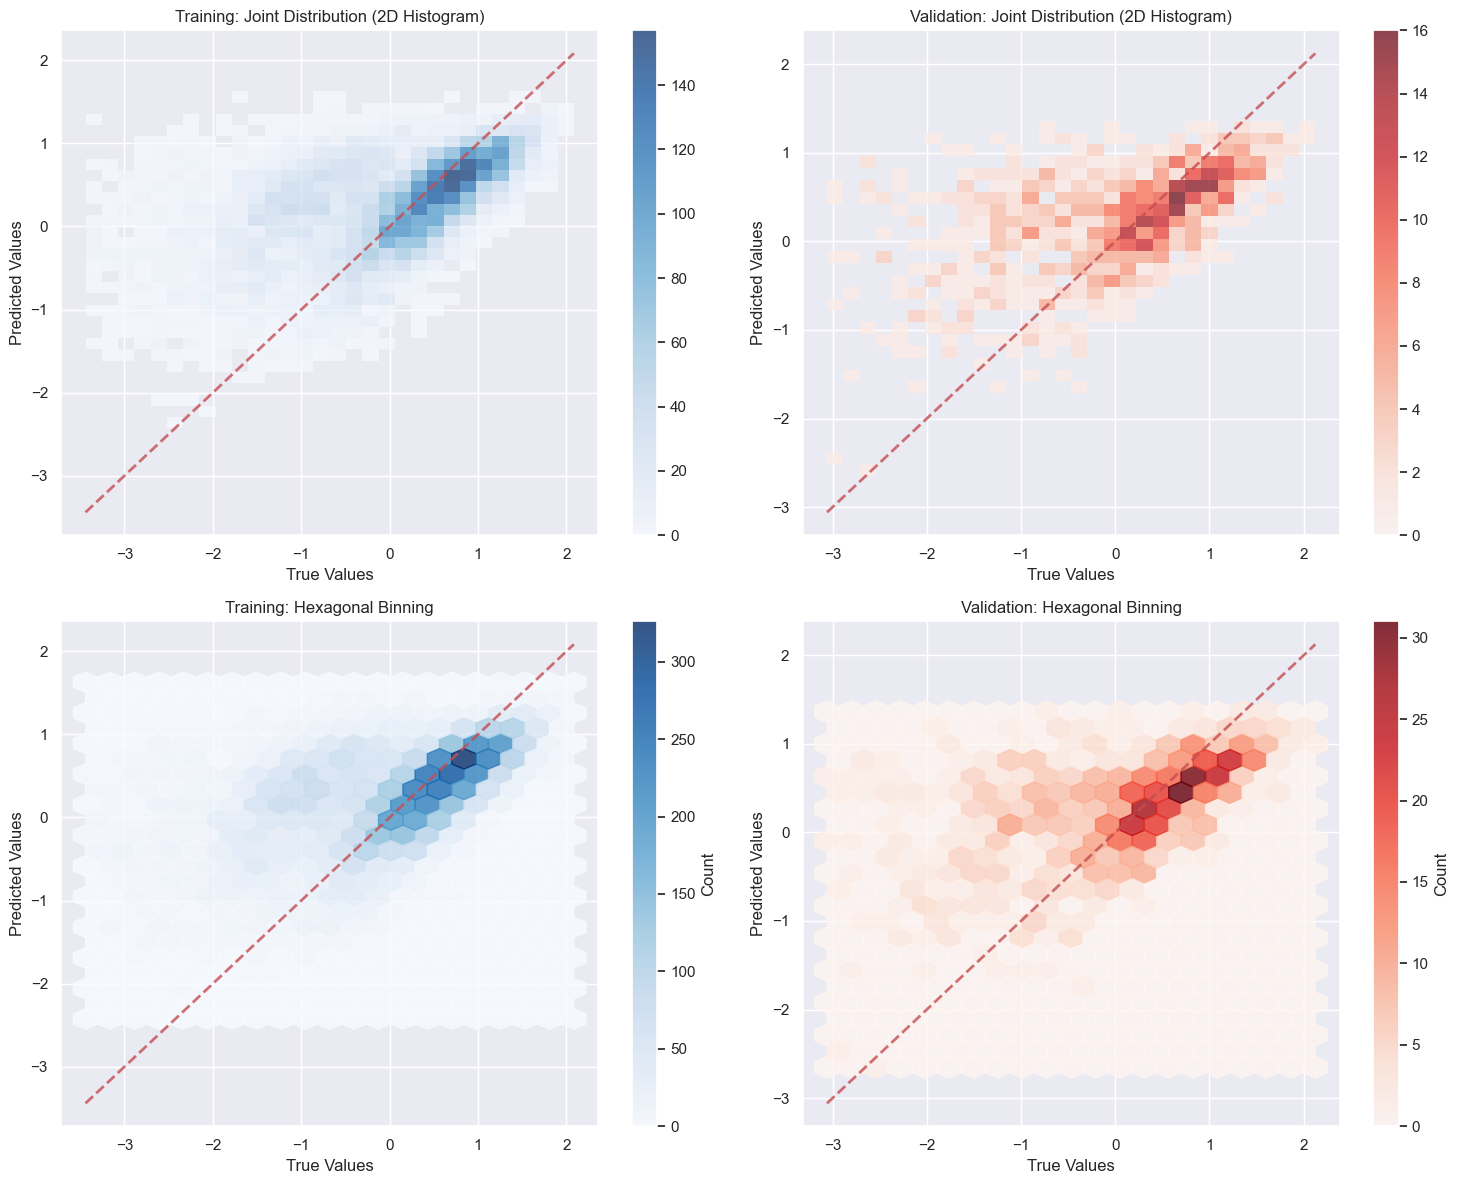

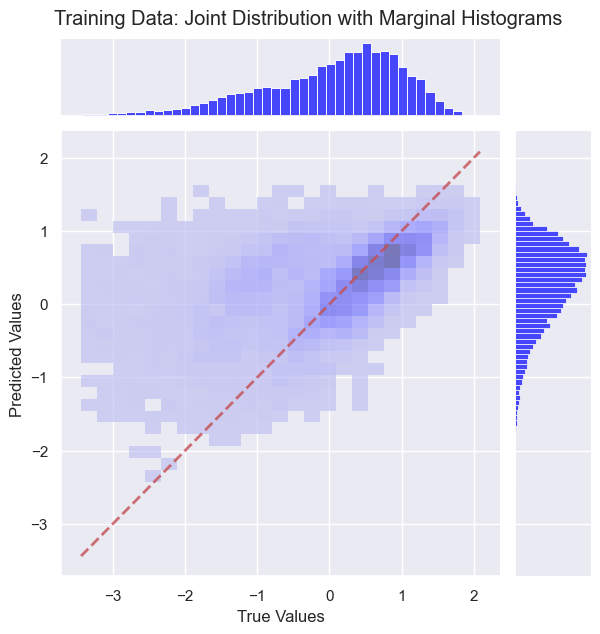

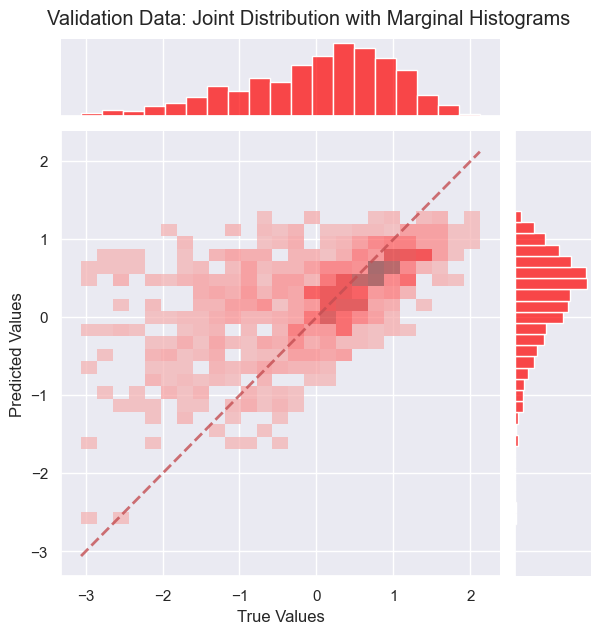

In [ ]:
# Create joint distribution plots with histograms and density
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Convert to numpy arrays for easier handling
train_true = trainDatasetReduced.data.y.cpu().numpy()
train_pred = train_predictions.cpu().numpy()
val_true = valDatasetReduced.data.y.cpu().numpy()
val_pred = val_predictions.cpu().numpy()

# Plot 1: Training data - Joint plot with marginal histograms
plt.subplot(2, 2, 1)
sns.histplot(x=train_true, y=train_pred, bins=30, alpha=0.7, cmap='Blues', cbar=True)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training: Joint Distribution (2D Histogram)')
# Add diagonal line
min_val = min(train_true.min(), train_pred.min())
max_val = max(train_true.max(), train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

# Plot 2: Validation data - Joint plot with marginal histograms
plt.subplot(2, 2, 2)
sns.histplot(x=val_true, y=val_pred, bins=30, alpha=0.7, cmap='Reds', cbar=True)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Validation: Joint Distribution (2D Histogram)')
# Add diagonal line
min_val = min(val_true.min(), val_pred.min())
max_val = max(val_true.max(), val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

# Plot 3: Hexbin plot for training data
plt.subplot(2, 2, 3)
plt.hexbin(train_true, train_pred, gridsize=20, cmap='Blues', alpha=0.8)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training: Hexagonal Binning')
plt.colorbar(label='Count')
# Add diagonal line
min_val = min(train_true.min(), train_pred.min())
max_val = max(train_true.max(), train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

# Plot 4: Hexbin plot for validation data
plt.subplot(2, 2, 4)
plt.hexbin(val_true, val_pred, gridsize=20, cmap='Reds', alpha=0.8)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Validation: Hexagonal Binning')
plt.colorbar(label='Count')
# Add diagonal line
min_val = min(val_true.min(), val_pred.min())
max_val = max(val_true.max(), val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

plt.tight_layout()
plt.savefig('saved_models/Pipeline/Attention/joint_distribution_hist.png', dpi=300, bbox_inches='tight')
plt.show()

# Create separate figures with seaborn's jointplot for better marginal distributions
g1 = sns.jointplot(x=train_true, y=train_pred, kind='hist', bins=25, 
                   color='blue', alpha=0.7, marginal_kws={'alpha': 0.7})
g1.ax_joint.plot([train_true.min(), train_true.max()], 
                 [train_true.min(), train_true.max()], 'r--', alpha=0.8, linewidth=2)
g1.set_axis_labels('True Values', 'Predicted Values')
g1.fig.suptitle('Training Data: Joint Distribution with Marginal Histograms', y=1.02)

# Validation data jointplot
g2 = sns.jointplot(x=val_true, y=val_pred, kind='hist', bins=25, 
                   color='red', alpha=0.7, marginal_kws={'alpha': 0.7})
g2.ax_joint.plot([val_true.min(), val_true.max()], 
                 [val_true.min(), val_true.max()], 'r--', alpha=0.8, linewidth=2)
g2.set_axis_labels('True Values', 'Predicted Values')
g2.fig.suptitle('Validation Data: Joint Distribution with Marginal Histograms', y=1.02)

plt.savefig('saved_models/Pipeline/Attention/joint_marginal_hist.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import tqdm.notebook as tqdm


train_embeddings = []
train_targets = []

bestModel.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bestModel = bestModel.to(device)

with torch.no_grad():
    for batch in tqdm.tqdm(train_loader, desc="Extracting train embeddings"):
        # Move batch to GPU
        batch = batch.to(device)
        # Get embeddings from the model (before final prediction layer)
        embeddings = bestModel.get_embeddings(
            x=batch.x,
            edge_index=batch.edge_index,
            edge_attr=batch.edge_attr,
            batch=batch.batch
        )
        train_embeddings.append(embeddings.cpu())  # Move to CPU for storage
        train_targets.append(batch.y.cpu())

train_embeddings = torch.cat(train_embeddings, dim=0)
train_targets = torch.cat(train_targets, dim=0)

val_embeddings = []
val_targets = []

with torch.no_grad():
    for batch in tqdm.tqdm(val_loader, desc="Extracting val embeddings"):
        # Move batch to GPU
        batch = batch.to(device)
        embeddings = bestModel.get_embeddings(
            x=batch.x,
            edge_index=batch.edge_index,
            edge_attr=batch.edge_attr,
            batch=batch.batch
        )
        val_embeddings.append(embeddings.cpu())  # Move to CPU for storage
        val_targets.append(batch.y.cpu())

val_embeddings = torch.cat(val_embeddings, dim=0)
val_targets = torch.cat(val_targets, dim=0)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Val embeddings shape: {val_embeddings.shape}")
print(f"Train targets shape: {train_targets.shape}")
print(f"Val targets shape: {val_targets.shape}")

Extracting train embeddings:   0%|          | 0/310 [00:00<?, ?it/s]

Extracting val embeddings:   0%|          | 0/31 [00:00<?, ?it/s]

Train embeddings shape: torch.Size([9893, 64])
Val embeddings shape: torch.Size([988, 64])
Train targets shape: torch.Size([9893])
Val targets shape: torch.Size([988])


Combined embeddings shape: torch.Size([10881, 64])
Combined targets shape: torch.Size([10881])
Combined predictions shape: (10881,)
Applying t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10881 samples in 0.001s...
[t-SNE] Computed neighbors for 10881 samples in 3.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10881
[t-SNE] Computed conditional probabilities for sample 2000 / 10881
[t-SNE] Computed conditional probabilities for sample 3000 / 10881
[t-SNE] Computed conditional probabilities for sample 4000 / 10881
[t-SNE] Computed conditional probabilities for sample 5000 / 10881
[t-SNE] Computed neighbors for 10881 samples in 3.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10881
[t-SNE] Computed conditional probabilities for sample 2000 / 10881
[t-SNE] Computed conditional probabilities for sample 3000 / 10881
[t-SNE] Computed conditional probabilities for sample 4000 / 10881
[t-SNE] Computed conditional probabilities for

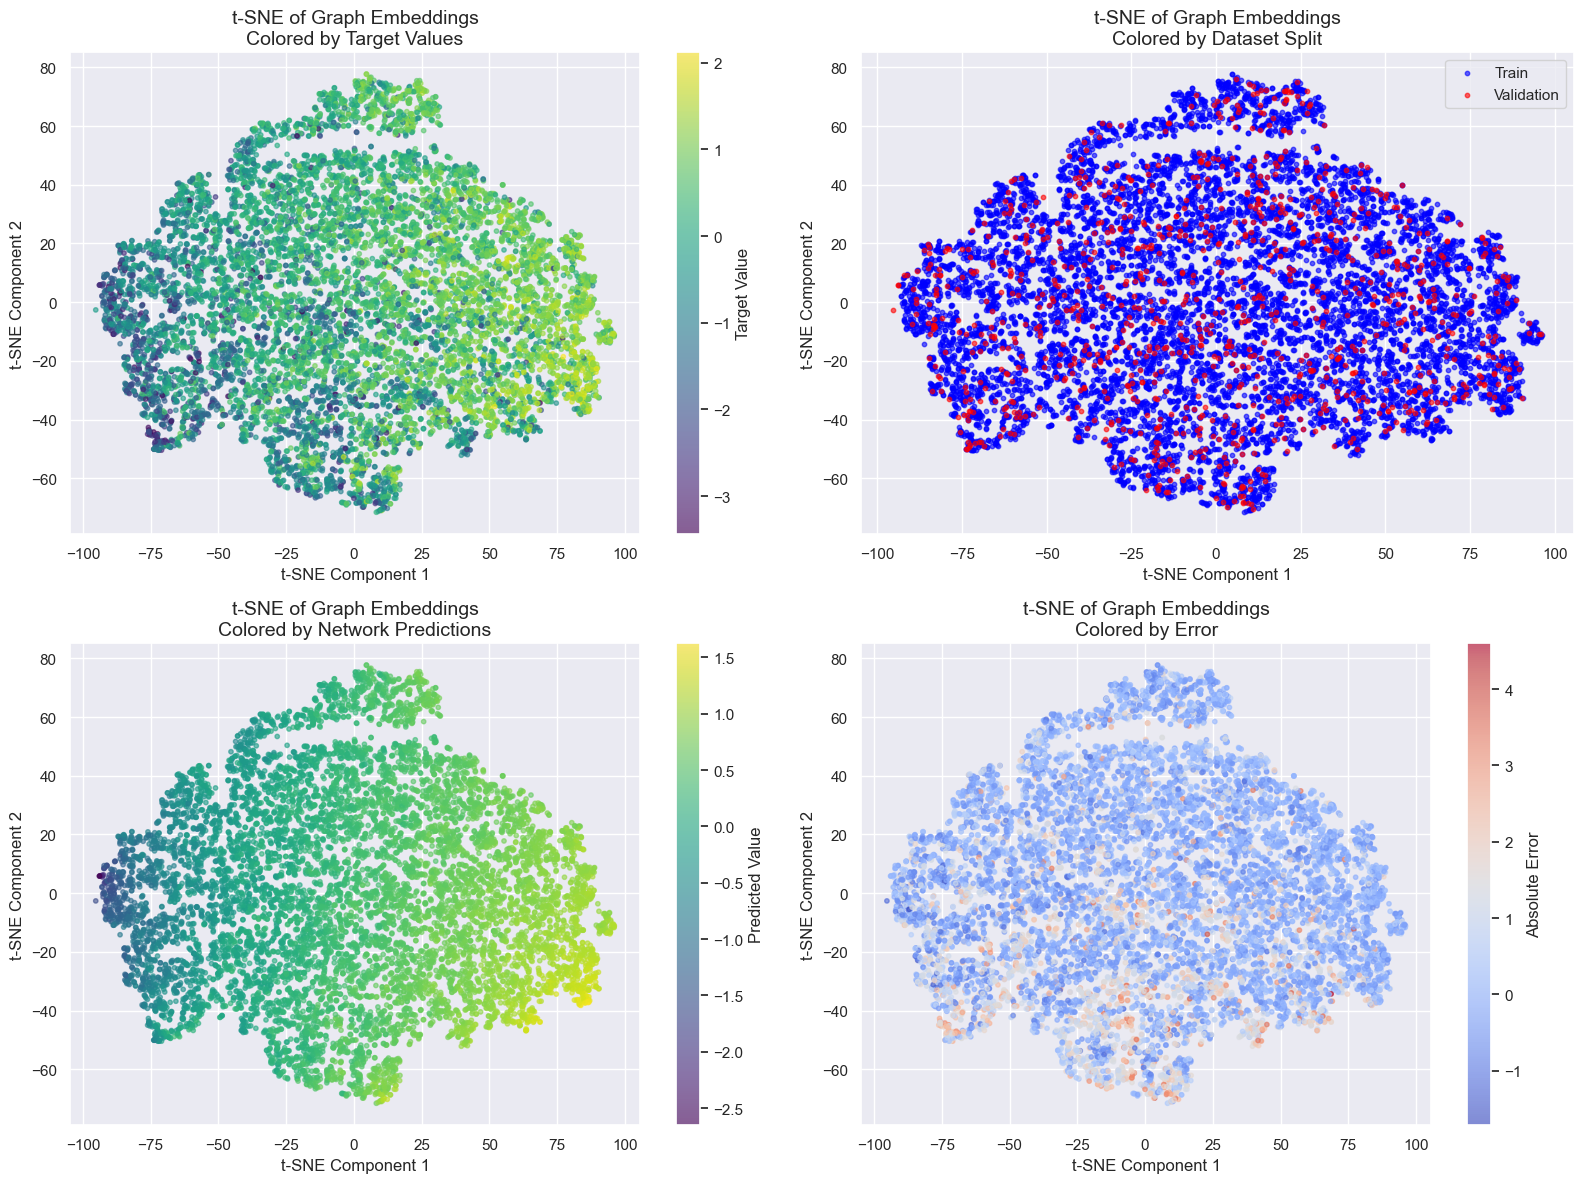


Target value statistics:
Min: -3.4398
Max: 2.1231
Mean: -0.0000
Std: 0.9999

Prediction value statistics:
Min: -2.6518
Max: 1.6272
Mean: 0.2613
Std: 0.5670

Absolute error statistics:
Min: -1.7140
Max: 4.6009
Mean: 0.2613
Std: 0.8557


In [ ]:
# Install required packages for t-SNE visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Combine train and validation embeddings and targets
all_embeddings = torch.cat([train_embeddings, val_embeddings], dim=0)
all_targets = torch.cat([train_targets, val_targets], dim=0)
dataset_labels = ['Train'] * len(train_embeddings) + ['Val'] * len(val_embeddings)

# Combine XGBoost predictions
all_predictions = np.concatenate([train_predictions.cpu().numpy(), val_predictions.cpu().numpy()])

print(f"Combined embeddings shape: {all_embeddings.shape}")
print(f"Combined targets shape: {all_targets.shape}")
print(f"Combined predictions shape: {all_predictions.shape}")

# Convert to numpy for t-SNE
embeddings_np = all_embeddings.cpu().numpy()
targets_np = all_targets.cpu().numpy()

# Calculate absolute error
absolute_errors = all_predictions - targets_np

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1, n_jobs=-1)
embeddings_2d = tsne.fit_transform(embeddings_np)

print(f"t-SNE completed. Shape: {embeddings_2d.shape}")

# Create the plot with four subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Colored by target values
scatter1 = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=targets_np, cmap='viridis', alpha=0.6, s=10)
ax1.set_title('t-SNE of Graph Embeddings\nColored by Target Values', fontsize=14)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Target Value')

# Plot 2: Colored by dataset (train/val)
train_mask = np.array(dataset_labels) == 'Train'
val_mask = np.array(dataset_labels) == 'Val'

ax2.scatter(embeddings_2d[train_mask, 0], embeddings_2d[train_mask, 1], 
           c='blue', alpha=0.6, s=10, label='Train')
ax2.scatter(embeddings_2d[val_mask, 0], embeddings_2d[val_mask, 1], 
           c='red', alpha=0.6, s=10, label='Validation')
ax2.set_title('t-SNE of Graph Embeddings\nColored by Dataset Split', fontsize=14)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.legend()

# Plot 3: Colored by Network predictions
scatter3 = ax3.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=all_predictions, cmap='viridis', alpha=0.6, s=10)
ax3.set_title('t-SNE of Graph Embeddings\nColored by Network Predictions', fontsize=14)
ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Predicted Value')

# Plot 4: Colored by absolute error
scatter4 = ax4.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=absolute_errors, cmap='coolwarm', alpha=0.6, s=10)
ax4.set_title('t-SNE of Graph Embeddings\nColored by Error', fontsize=14)
ax4.set_xlabel('t-SNE Component 1')
ax4.set_ylabel('t-SNE Component 2')
cbar4 = plt.colorbar(scatter4, ax=ax4)
cbar4.set_label('Absolute Error')

plt.tight_layout()
plt.savefig('saved_models/Pipeline/Attention/tsne_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

# Print some statistics
print(f"\nTarget value statistics:")
print(f"Min: {targets_np.min():.4f}")
print(f"Max: {targets_np.max():.4f}")
print(f"Mean: {targets_np.mean():.4f}")
print(f"Std: {targets_np.std():.4f}")

print(f"\nPrediction value statistics:")
print(f"Min: {all_predictions.min():.4f}")
print(f"Max: {all_predictions.max():.4f}")
print(f"Mean: {all_predictions.mean():.4f}")
print(f"Std: {all_predictions.std():.4f}")

print(f"\nAbsolute error statistics:")
print(f"Min: {absolute_errors.min():.4f}")
print(f"Max: {absolute_errors.max():.4f}")
print(f"Mean: {absolute_errors.mean():.4f}")
print(f"Std: {absolute_errors.std():.4f}")


XGBoost Regression Validation Metrics:
Mean Squared Error (MSE): 0.3284
R-squared (R2): 0.6712
Mean Absolute Error (MAE): 0.4140


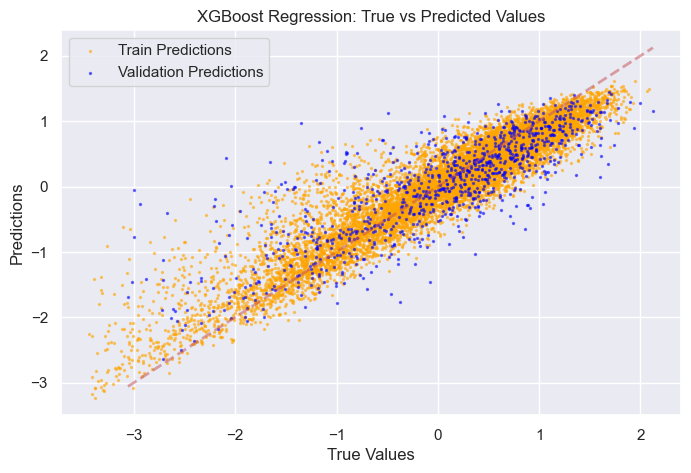

In [ ]:
#Run xgboostRegression on the embeddings and print validation metrics
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare training and validation data
X_train = train_embeddings.cpu().numpy()
y_train = train_targets.cpu().numpy()
X_val = val_embeddings.cpu().numpy()
y_val = val_targets.cpu().numpy()

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    n_jobs=-1,)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
# Calculate metrics
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)

print(f"\nXGBoost Regression Validation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot true vs predicted values for XGBoost
plotTrueVsPred(
    y=y_train,
    y_pred=y_pred,
    y_val=y_val,
    y_val_pred=y_val_pred,
    title="XGBoost Regression: True vs Predicted Values",
    filename="saved_models/Pipeline/Attention/xgboost_true_vs_pred.png",
    hardLimit=False
)

[LibSVM]
SVR Regression Validation Metrics:
Mean Squared Error (MSE): 0.4144
R-squared (R2): 0.5852
Mean Absolute Error (MAE): 0.4831

SVR Regression Validation Metrics:
Mean Squared Error (MSE): 0.4144
R-squared (R2): 0.5852
Mean Absolute Error (MAE): 0.4831


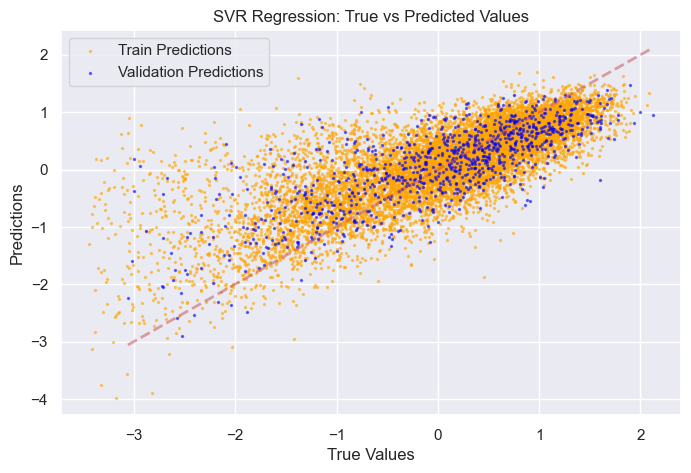

W&B state cleaned up. Ready for Optuna optimization!
=== Best Trial Analysis ===


RuntimeError: A single best trial cannot be retrieved from a multi-objective study. Consider using Study.best_trials to retrieve a list containing the best trials.

In [ ]:
#SVR Regression on the embeddings and print validation metrics
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1, verbose=True)
# Train the SVR model
svr_model.fit(X_train, y_train)
# Make predictions
y_svr_pred = svr_model.predict(X_train)
y_svr_pred_val = svr_model.predict(X_val)
# Calculate metrics for SVR
mse_svr = mean_squared_error(y_val, y_svr_pred_val)
r2_svr = r2_score(y_val, y_svr_pred_val)
mae_svr = mean_absolute_error(y_val, y_svr_pred_val)
print(f"\nSVR Regression Validation Metrics:")
print(f"Mean Squared Error (MSE): {mse_svr:.4f}")
print(f"R-squared (R2): {r2_svr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_svr:.4f}")

# Plot true vs predicted values for SVR
plotTrueVsPred(
    y=y_train,
    y_pred=y_svr_pred,
    y_val=y_val,
    y_val_pred=y_svr_pred_val,
    title="SVR Regression: True vs Predicted Values",
    filename="saved_models/Pipeline/Attention/svr_true_vs_pred.png",
    hardLimit=False
)